# Introduction to Eager and Graph mode NPU inference

In this Jupyter Notebook, we explore the concepts of Eager and Graph mode NPU inference. 

Eager mode allows us to execute operations immediately as they are called, providing a more interactive and dynamic programming experience. On the other hand, Graph mode allows us to optimize and compile the operations into a computational graph, which can lead to improved performance and efficiency.

Throughout this notebook, we will demonstrate the usage of Eager and Graph mode for NPU inference using various examples and code snippets. We will also explore the visualization of computation graphs and compare the execution times of CPU and NPU implementations.

Let's dive in!


In the next cell, we define some visualization utilities to visualize NPU models and kernels. These utilities are used to generate a graphical representation of the computation graph of the NPU models and kernels.

To visualize the computation graph, we use the `netron` package in Python. `netron` is a viewer for neural network models, and it provides an interactive visualization of the computation graph.

To use the `netron` package, it needs to be installed in the Python environment. You can install it by running the following command in a code cell:

```bash
pip install netron
```

After installing the `netron` package, you can use it to visualize the computation graph of NPU models and kernels by calling the `visualize_factory()` or `visualize_computation_graph()` functions defined in the previous cell. These functions save the computation graph as an XML file and open it in the `netron` viewer, which can be accessed through a web browser.

The visualization utilities provide a convenient way to understand the structure and connections of NPU models and kernels, making it easier to analyze and debug the neural network inference process.

In [1]:
#
# Copyright © 2024 Intel Corporation
# SPDX-License-Identifier: Apache 2.0
#


from intel_npu_acceleration_library.nn.module import NPUContextManager
import intel_npu_acceleration_library as npu_lib
import IPython
import netron
import torch


def visualize_factory(factory, name="model.xml", port=8081):
    factory.save(name)
    netron.start(name, port, browse=False)
    display(IPython.display.IFrame(f"http://localhost:{port}", width=640, height=480))
    
def visualize_computation_graph(tensor, name="model.xml", port=8081):
    visualize_factory(tensor.factory, name, port)


def visualize_model(model, name="model.xml", port=8081):
    factory = list(model._nn_factory_cache.values())[0]
    visualize_factory(factory, name, port)



C:\Users\Local_Admin\Desktop\LLM\intel-npu-acceleration-library\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run a simple convolution on CPU

Create a simple CPU convolution using torch. We'll then compare it with NPU inference


In [2]:

x = torch.rand((1, 128, 64, 64), dtype=torch.float16)
weights = torch.rand((256, 128, 1, 1), dtype=torch.float16)
bias = torch.rand((256,), dtype=torch.float16)

conv_out_cpu = torch.nn.functional.conv2d(x, weights, bias=bias)



Eager mode execution in the context of the NPU allows operations to be executed immediately as they are called. This provides a more interactive and dynamic programming experience, where each operation is executed and the results are immediately available. Eager mode is useful for debugging and prototyping, as it allows for easy inspection of intermediate results and quick iteration.

In eager mode, the NPU Acceleration Library generates JIT (Just-in-Time) kernels that do not include weights. Instead, the weights are passed as inputs to the kernel. This design allows for the reutilization of the kernel across multiple inferences, enabling the execution of topologically similar blocks with different parameters.

On the other hand, graph mode execution in the context of the NPU involves optimizing and compiling the operations into a computational graph. This graph represents the sequence of operations to be executed and their dependencies. Graph mode can lead to improved performance and efficiency, as the graph can be optimized and executed more efficiently than individual operations. Graph mode is particularly useful for large-scale computations and production deployments, where performance is a critical factor.

In summary, eager mode provides a more interactive and dynamic programming experience, while graph mode offers improved performance and efficiency. The choice between eager and graph mode depends on the specific requirements of the application and the trade-offs between interactivity and performance.


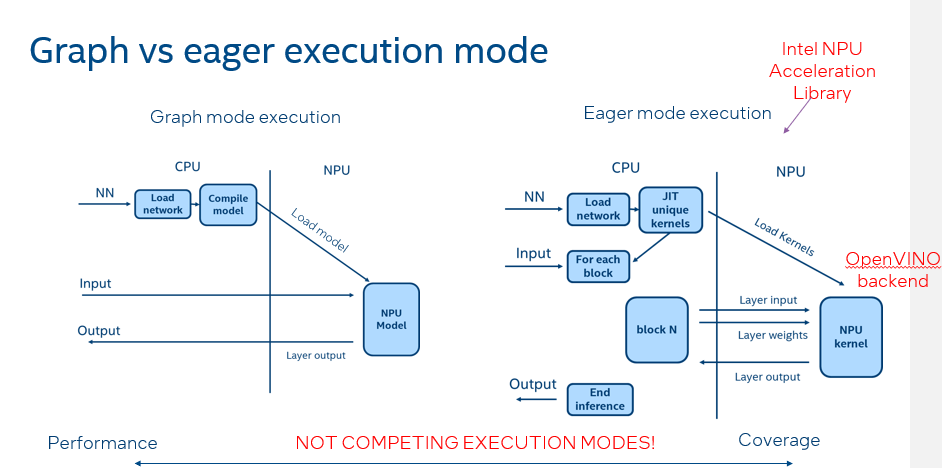



## Same operation on NPU in graph mode

The next cell performs the same operation on the NPU in graph mode.

This code creates a context manager `graph_model` using `NPUContextManager()`. Inside the context manager, it creates a tensor `x_t` with the same shape and data type as `x`. Then, it performs a convolution operation using `torch.nn.functional.conv2d()` with the tensor `x_t`, `weights`, and `bias`. The result is stored in the variable `out`. Finally, it executes the graph model on the NPU using `graph_model(x)` and stores the result in `conv_out_npu_graph`.

In [ ]:
with NPUContextManager() as graph_model:
    x_t = graph_model.Tensor(x.shape, x.dtype)

    out = torch.nn.functional.conv2d(x_t, weights, bias=bias)

conv_out_npu_graph = graph_model(x)

visualize_computation_graph(out)

## Same operation on NPU in eager mode

The next cell performs the same operation on the NPU in eager mode.

This code creates a context manager `eager_model` using `NPUContextManager()`. Inside the context manager, it creates tensors `x_t`, `weights_t`, and `bias_t` with the same shape and data types as `x`, `weights`, and `bias` respectively. Then, it performs a convolution operation using `torch.nn.functional.conv2d()` with the tensors `x_t`, `weights_t`, and `bias_t`. The result is stored in the variable `out`. Finally, it executes the eager model on the NPU using `eager_model(x, weights, bias)` and stores the result in `conv_out_npu_eager`. 

The main difference at execution level is that `eager_model` takes `weights` and `bias` as inputs while `graph_model` only takes `x`. This is because in graph mode the weights are already embedded into the NPU network offloaded to the NPU

In [ ]:

with NPUContextManager() as eager_model:
    x_t = eager_model.Tensor(x.shape, dtype=x.dtype)
    weights_t = eager_model.Tensor(weights.shape, dtype=weights.dtype)
    bias_t = eager_model.Tensor(bias.shape, dtype=bias.dtype)

    out = torch.nn.functional.conv2d(x_t, weights_t, bias=bias_t)

conv_out_npu_graph = eager_model(x, weights, bias)

visualize_computation_graph(out)


## Compare execution of CPU, NPU graph and NPU eager mode

To compare the execution of CPU, NPU graph mode, and NPU eager mode, we can use the `timeit` magic command in Jupyter Notebook. Here's the code:


In [5]:
print("CPU")

%timeit torch.nn.functional.conv2d(x, weights, bias=bias)

print("NPU eager mode")

%timeit eager_model(x, weights, bias)

print("NPU graph mode")

%timeit graph_model(x)

CPU
158 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
NPU eager mode
1.29 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
NPU graph mode
775 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As expected NPU is faster than CPU for such operation, with graph mode being the fastest mode of execution as the weights and bias are already part of the model.

## Use Modules

To use the NPU in a torch-friendly way, you can simply use the `to` syntax provided by PyTorch. This allows you to easily transfer your torch modules and tensors to the NPU device for accelerated computation.
By using the `to` syntax, you can seamlessly integrate the NPU into your torch workflow and take advantage of its accelerated computation capabilities.

Here's an example of how to define and use a torch module that utilizes the NPU:


In [6]:
import torch

class NNModule(torch.nn.Module):
    def __init__(self):
        super(NNModule, self).__init__()
        self.conv1 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.relu3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.relu4 = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc = torch.nn.Linear(256*16*16, 10)

    def forward(self, x):
        x =  self.relu1(self.conv1(x))
        x =  self.relu2(self.conv2(x))
        x =  self.relu3(self.conv3(x))
        x =  self.relu4(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 256*16*16)
        x = self.fc(x)
        return x


model = NNModule()

model



NNModule(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)

In [7]:
x = torch.randn(1, 256, 32, 32)

%timeit model(x) 

9.61 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Run a module in the NPU


To offload the model to the NPU, you can simply use the `to` syntax provided by PyTorch. By calling `model.to("npu")`, the model and its parameters will be transferred to the NPU device for accelerated computation. Here's the code:

```python
model.to("npu")
```

After executing this code, the model will be offloaded to the NPU and all subsequent operations performed on the model will be executed on the NPU.

In [8]:
model = model.to("npu")

model

NPUModuleWrapper(
  (module): NNModule(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=65536, out_features=10, bias=True)
  )
)

In [9]:
# In the first inference the model is compiled
_ = model(x)

%timeit model(x) 

1.56 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Implement custom kernels

In this section we are goinig to create custom NPU kernels. The example we are going to follow is about [Phi3MLP](https://github.com/huggingface/transformers/blob/main/src/transformers/models/phi3/modeling_phi3.py#L243) kernel. 

As a first step, we should define the equivalent, weight-less NPU kernel. Note that the forward method has the weights as input parameter. That reflect the fact that it is a NPU kernel.

In [10]:
from intel_npu_acceleration_library.nn.module import Module
from transformers.models.phi3.modeling_phi3 import Phi3MLP
import uuid

class Phi3NPUKernel(npu_lib.nn.Module):
    def __init__(self, config, activation_fn):
        super().__init__()
        self.config = config
        self.activation_fn = activation_fn

    def forward(self, hidden_states, gate_up_proj_w, down_proj_w, **kwargs):
        gate_up_states = torch.nn.functional.linear(hidden_states, gate_up_proj_w)

        gate = gate_up_states[..., :self.config.intermediate_size]
        up_states = gate_up_states[..., self.config.intermediate_size:]

        up_states = up_states * self.activation_fn(gate)

        return torch.nn.functional.linear(up_states, down_proj_w)
        

We then create a wrapper around the `Phi3MLP` layer. This module inherit from Phi3MLP and also has the previously defined `Phi3NPUKernel` as a module.

We then override the `forward` method to use the `npu_kernel` we defined earlier with the layer weights.

In [11]:
class NPUPhi3MLP(Phi3MLP):
    def __init__(self, config):
        super().__init__(config)
        self.npu_kernel = Phi3NPUKernel(config, self.activation_fn).to("npu")
        # Useful to mark kernel and optimize weight loading
        self.op_id = str(uuid.uuid4())
    
    def forward(self, hidden_states):
        return self.npu_kernel(hidden_states, self.gate_up_proj.weight, self.down_proj.weight, op_id=self.op_id)
        

## Implementation of PHI3 MLP in eager and graph mode

The same can be done in graph mode by simply using the `to` syntax. Profiling the three shows the performance boost we get by running such model on NPU

In [12]:
from transformers import AutoConfig

conf = AutoConfig.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

npu_phi3_mlp = NPUPhi3MLP(conf).half()

hidden_states = torch.rand((128, conf.hidden_size)).half()
_ = npu_phi3_mlp(hidden_states)

print("NPU eager mode")
%timeit npu_phi3_mlp(hidden_states)

phi3_graph = npu_phi3_mlp.to("npu")
_ = phi3_graph(hidden_states)

print("NPU graph mode")
%timeit phi3_graph(hidden_states)


NPU eager mode
37.1 ms ± 89.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
NPU graph mode
36.4 ms ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Visualize the Phi3 MLP NPU kernel and graph


In [ ]:
print("NPU kernel")
visualize_model(npu_phi3_mlp.npu_kernel)


In [ ]:
print("NPU graph")
visualize_model(phi3_graph)


## Export a generated model to OpenVINO\

Under the hood Intel NPU acceleration library uses OpenVINO to describe the models. Because of that, it is easy to export generated kernels to OV to productize them later. This allows to use this library to fast prototype networks on the Intel NPU.

In [15]:
model._nn_factory_cache['1_256_32_32_torch.float32'].save("ov_model.xml")